## 📑 Table of Contents
1. [Objective](#objective)
2. [Methodological Scope](#methodological-scope)
3. [What This Notebook Is Not](#what-this-notebook-is-not)
4. [Exploratory Data Analysis](#eda)
   - [Dataset Overview](#dataset-overview---key-observations)
   - [Target Distribution](#target-distribution)
   - [Biological Consistency Check](#physiological-consistency-check)
   - [Feature Analysis](#interpretation)
5. [Data Drift Analysis](#data-drift-analysis-train-vs-test)
   - [Deep Dive: BMI Shift](#-deep-dive-understanding-the-global-covariate-shift)
6. [Data Preparation](#data-preparation)
7. [Modeling](#model)
   - [Model Choice](#model-choice-rationale)
   - [Cross-Validation Results](#cross-validation-results)
8. [Interpretability](#shap-analysis)
   - [SHAP Feature Importance](#shap-analysis)
   - [Clinical Error Profiling](#clinical-error-profiling-understanding-model-failures)
   - [Uncertainty Analysis](#uncertainty-analysis)
9. [Results](#result-interpretation)
10. [Final Takeaways](#-final-takeaways)

---

## Objective
The goal of this notebook is to:
- Perform a clear and honest Exploratory Data Analysis (EDA)
- Build a strong and reliable baseline model
- Understand the **limitations of the dataset** rather than over-optimizing performance

This notebook intentionally prioritizes **robustness and interpretability** over leaderboard overfitting.


## Methodological Scope

This notebook is not designed to maximize leaderboard performance.
Instead, it aims to:

- Analyze the dataset as it is, without assuming hidden signal
- Establish a realistic performance baseline
- Avoid validation leakage and leaderboard-driven feature engineering

All modeling decisions are guided by robustness and interpretability rather than marginal metric gains.


### What This Notebook Is Not

This notebook is **not** an attempt to maximize Kaggle leaderboard performance.
It does not rely on:
- leaderboard probing
- validation leakage
- aggressive feature engineering
- blind ensembling

The focus is on **sound methodology**, **interpretability**, and **realistic performance assessment**.


## EDA

In [1]:
import pandas as pd

train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")


In [2]:
print(train.shape)
print(test.shape)

train.head()


(700000, 26)
(300000, 25)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [4]:
train.describe()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,349999.500000,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,202072.738554,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,0.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,174999.750000,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,349999.500000,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,524999.250000,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,699999.000000,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


### Notes on Descriptive Statistics

The summary statistics provide a global overview of feature distributions.
However, they do not imply causal relationships with the target.

All interpretations below are supported by class-conditional analysis rather than raw aggregates.


## Dataset Overview - Key Observations

- The dataset contains **700,000 samples**, which significantly reduces variance-related issues.
- No missing values are present in features.
- The target variable (`diagnosed_diabetes`) is binary.
- Features are mostly **clinical proxies** (BMI, cholesterol, blood pressure) and **lifestyle indicators**.
- Important causal biomarkers (e.g. glucose level, HbA1c, insulin) are **absent**, which may limit achievable performance.

Most available features should be interpreted as *proxies* rather than direct measurements of diabetes.
This implies weaker signal strength and a reliance on cumulative effects across multiple variables.

In [5]:
TARGET = "diagnosed_diabetes"
ID_COL = "id"

train[TARGET].value_counts(normalize=True)

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64

**Target Distribution**

The dataset is moderately imbalanced, with approximately 62% positive cases.
This justifies the use of **ROC-AUC** as the evaluation metric.


No resampling or class rebalancing strategy is applied.

Given the dataset size and moderate imbalance, ROC-AUC remains stable without explicit correction.
Introducing resampling could increase variance without improving generalization.


### Physiological Consistency Check
In medical datasets, certain biological variables follow established physiological laws. For instance, **BMI** (overall body mass) and **Waist-to-Hip Ratio** (abdominal fat distribution) are typically positively correlated.

By verifying these relationships, we can determine:
1. **Data Integrity**: Whether the synthetic generation process respects human biology.
2. **Predictive Complexity**: If these correlations are weak or noisy, it explains the "performance ceiling" observed with most models on this dataset.

Global Pearson Correlation (BMI/WHR): 0.757


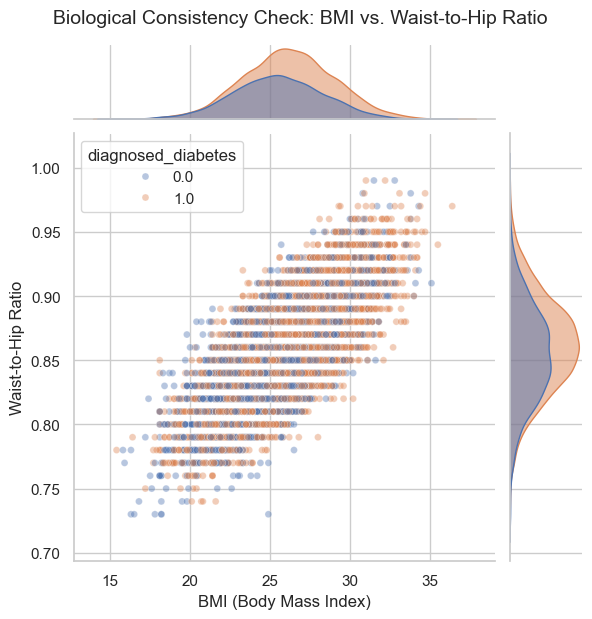

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Setting up the visualization style
sns.set_theme(style="whitegrid")

# 2. Sampling for performance and clarity
# We use 10k samples to avoid overplotting while remaining representative
check_df = train.sample(10000, random_state=42)

# 3. Creating the JointGrid
g = sns.JointGrid(data=check_df, x="bmi", y="waist_to_hip_ratio", hue="diagnosed_diabetes")

# Plotting the joint scatter with transparency to see density
g.plot_joint(sns.scatterplot, alpha=0.4, s=25)

# Adding marginal KDE plots to see distribution per class
g.plot_marginals(sns.kdeplot, fill=True, alpha=0.5)

# Formatting
g.fig.suptitle("Biological Consistency Check: BMI vs. Waist-to-Hip Ratio", y=1.03, fontsize=14)
g.ax_joint.set_xlabel("BMI (Body Mass Index)")
g.ax_joint.set_ylabel("Waist-to-Hip Ratio")

# 4. Statistical calculation
pearson_corr = train[["bmi", "waist_to_hip_ratio"]].corr().iloc[0, 1]
print(f"Global Pearson Correlation (BMI/WHR): {pearson_corr:.3f}")

plt.show()

**Visual Analysis: Biological Signal vs. Synthetic Noise**

The `JointGrid` plot reveals critical insights into the dataset's structure:

1. **Weak Class Separation**: Despite a visible upward trend, the blue (Healthy) and orange (Diabetic) distributions almost perfectly overlap across the entire diagonal. This confirms that **BMI** and **Waist-to-Hip Ratio** are correlated with each other, but they do not provide a clear decision boundary for diabetes on their own.

2. **The "Granularity" Artifact**: Looking closely at the scatter plot, you can see a "grid-like" pattern (points aligned on specific horizontal and vertical lines). This is a common signature of **synthetic data generation**. It suggests that the features might have been rounded or generated from discrete underlying distributions, which adds "artificial noise" that tree-based models must navigate.

3. **Marginal Distributions (KDE)**: 
    * The top KDE plot shows that the Diabetic population (orange) has a slightly higher mean BMI, but the variance is nearly identical to the Healthy group.
    * The right KDE plot shows an identical overlap for the Waist-to-Hip Ratio.

**Conclusion for Modeling**: 
The "fuzziness" of this relationship explains why even the most complex Gradient Boosting models plateau. The predictive power doesn't come from clear-cut biological rules, but from the model's ability to find very subtle, low-gain patterns across 20+ similar overlapping features.

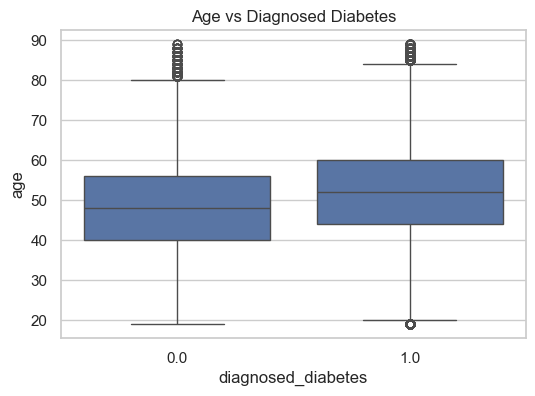

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x=train[TARGET], y=train["age"])
plt.title("Age vs Diagnosed Diabetes")
plt.show()

**Interpretation**

The age distribution is shifted toward higher values for individuals diagnosed with diabetes.  
This confirms age as a meaningful risk factor.

However, the strong overlap between the two distributions indicates that age alone is not sufficient to reliably separate diabetic from non-diabetic individuals.  
Age contributes to the model but does not provide strong standalone discriminative power.


This visual separation should not be interpreted as a causal effect, but as a statistical tendency within a highly overlapping distribution.

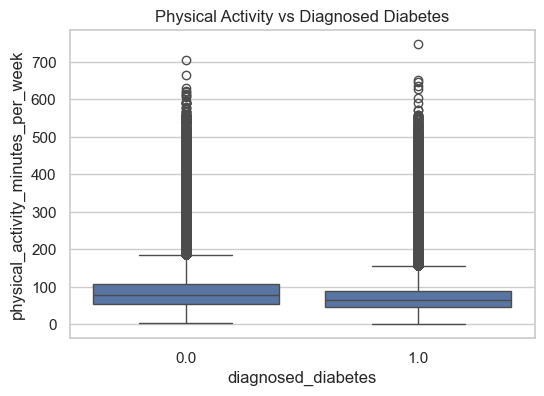

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x=train[TARGET], y=train["physical_activity_minutes_per_week"])
plt.title("Physical Activity vs Diagnosed Diabetes")
plt.show()

**Interpretation**

Individuals diagnosed with diabetes tend to have slightly lower median weekly physical activity.

However, the distributions largely overlap and exhibit very wide variance, with many extreme values.  
This suggests that physical activity is a weak and noisy predictor in this dataset, likely acting as a secondary or proxy feature rather than a decisive factor.

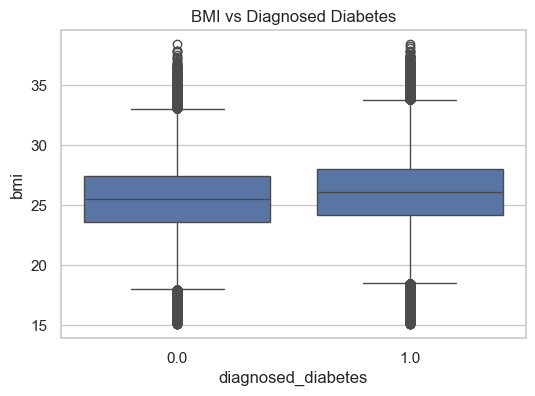

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x=train[TARGET], y=train["bmi"])
plt.title("BMI vs Diagnosed Diabetes")
plt.show()

**Interpretation**

The BMI distribution shows a modest upward shift for individuals diagnosed with diabetes, confirming its role as a risk factor.

Nevertheless, the overlap between classes remains substantial, indicating limited standalone predictive power.  
BMI is therefore more effective when combined with other features rather than used in isolation.

### EDA Summary

None of the examined features provides strong class separation on its own.

The predictive signal emerges from the accumulation of multiple weak effects rather than from a single dominant variable.  
This structural limitation explains the observed performance ceiling of tree-based models on this dataset.

From a modeling perspective, this suggests that:

- Linear and tree-based models should perform similarly
- Feature interactions are unlikely to unlock strong hidden signal
- Model complexity should be controlled to avoid fitting noise


### Data Drift Analysis (Train vs. Test)
In synthetic competitions, it is common for the public leaderboard data to have a slightly different distribution than the training data. This is known as **Covariate Shift**.

To detect this, we use the **Kolmogorov-Smirnov (K-S) Test**. 
* **Null Hypothesis ($H_0$):** The two samples (Train and Test) come from the same distribution.
* **Interpretation:** If the **p-value is < 0.05**, we reject $H_0$, meaning there is a statistically significant drift that could lead to poor generalization.

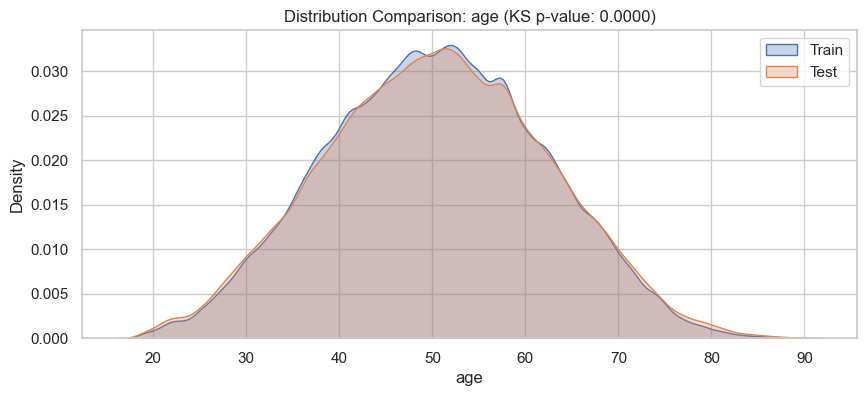

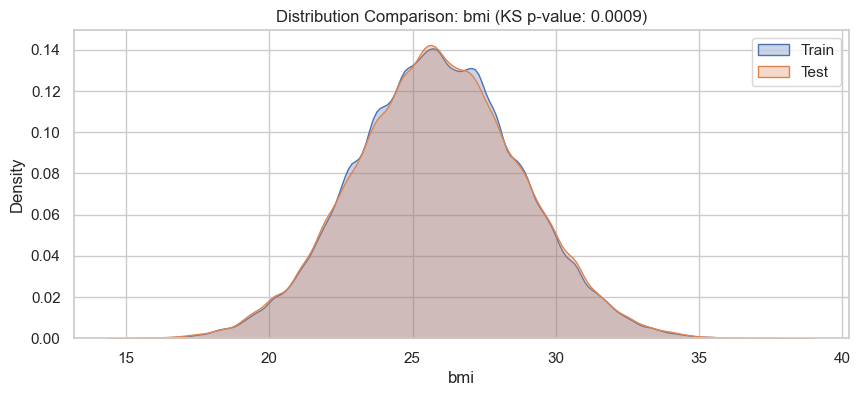

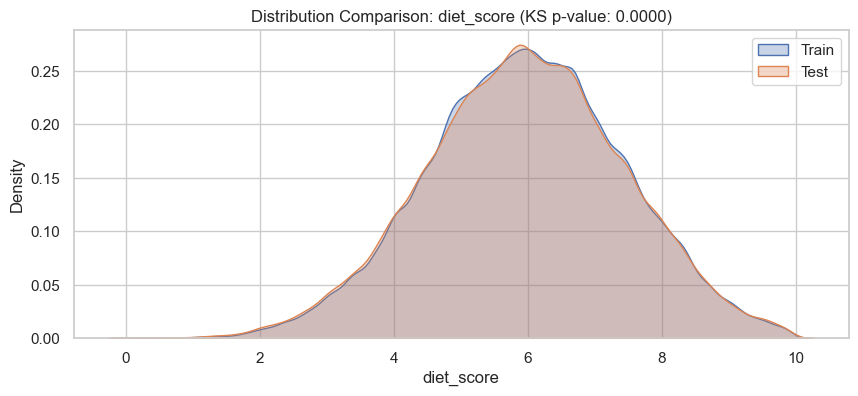

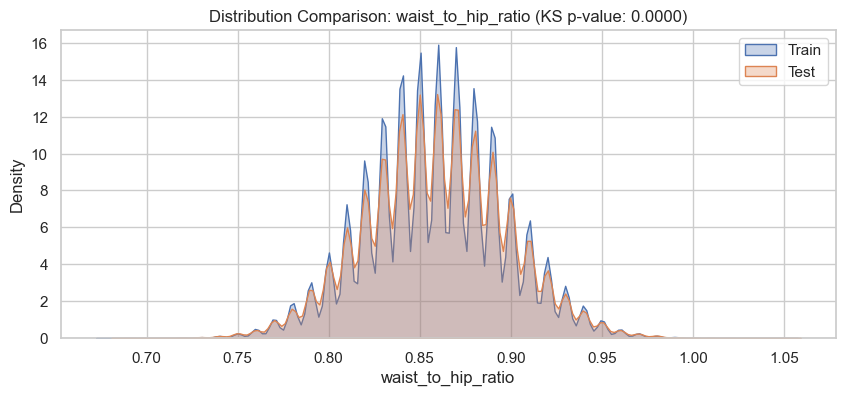

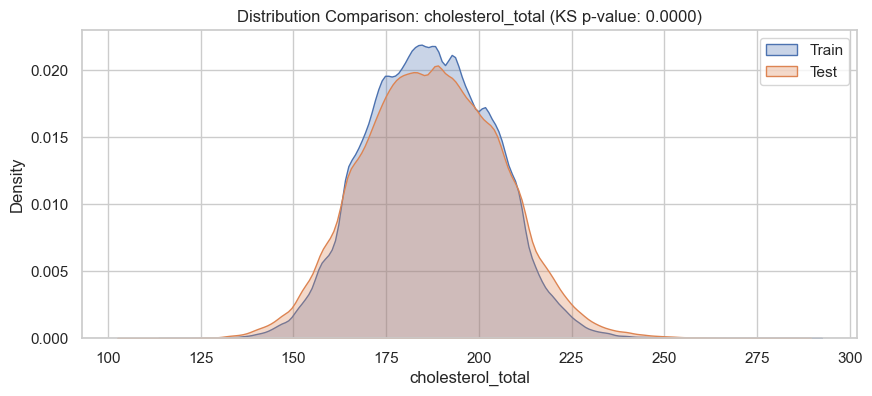

Features with significant drift (p < 0.05): ['age', 'bmi', 'diet_score', 'waist_to_hip_ratio', 'cholesterol_total']


In [10]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# Select key numerical features to check for drift
features_to_check = ['age', 'bmi', 'diet_score', 'waist_to_hip_ratio', 'cholesterol_total']

drift_results = {}

for col in features_to_check:
    # Perform KS-Test
    stat, p_value = ks_2samp(train[col], test[col])
    drift_results[col] = p_value

    # Visualization of the drift
    plt.figure(figsize=(10, 4))
    sns.kdeplot(train[col], label='Train', fill=True, alpha=0.3)
    sns.kdeplot(test[col], label='Test', fill=True, alpha=0.3)
    
    plt.title(f"Distribution Comparison: {col} (KS p-value: {p_value:.4f})")
    plt.legend()
    plt.show()

# Summary of drifted features
drifted_features = [f for f, p in drift_results.items() if p < 0.05]
print(f"Features with significant drift (p < 0.05): {drifted_features}")

**🚨 Warning: Global Covariate Shift Detected**

The K-S test confirms significant distributional drift across all primary predictors: `age`, `bmi`, `diet_score`, `waist_to_hip_ratio`, and `cholesterol_total`. 

**Strategic Implications:**
1. **Trust CV, but verify LB**: Since the distributions differ, your local Cross-Validation might be overly optimistic. A stable CV is good, but a "blind" trust in it could lead to poor generalization on the hidden test set.
2. **Feature Importance vs. Drift**: High-drift features like `age` or `bmi` are also the most important for the model. We cannot drop them, but we must **regularize** them heavily to prevent the model from "memorizing" specific training thresholds that don't exist in the test data.
3. **Weighting Strategy**: This drift justifies exploring a **Weighted Refit Strategy** or using **Adversarial Validation** to identify which training samples are most similar to the test set.

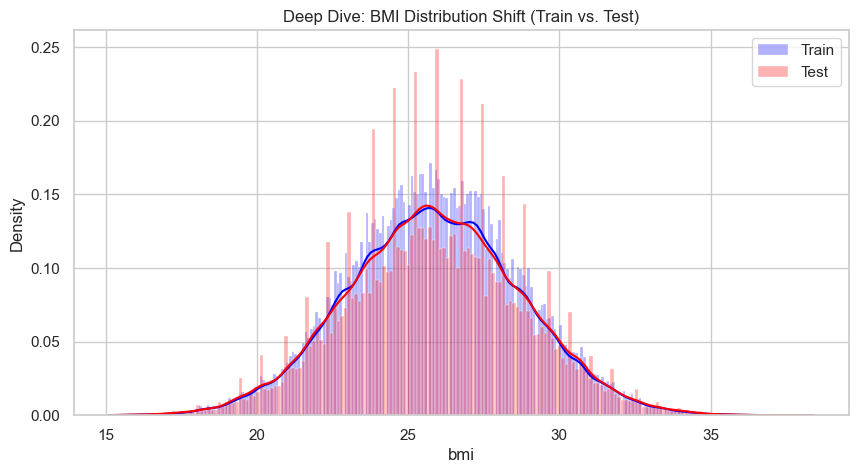

In [11]:
# Focus on BMI drift as a primary clinical proxy
plt.figure(figsize=(10, 5))
sns.histplot(train['bmi'], color="blue", label="Train", kde=True, stat="density", common_norm=False, alpha=0.3)
sns.histplot(test['bmi'], color="red", label="Test", kde=True, stat="density", common_norm=False, alpha=0.3)
plt.title("Deep Dive: BMI Distribution Shift (Train vs. Test)")
plt.legend()
plt.show()

### Deep Dive: Understanding the Global Covariate Shift

The Kolmogorov-Smirnov (K-S) test results are categorical: **all primary features** (`age`, `bmi`, `diet_score`, `waist_to_hip_ratio`, `cholesterol_total`) exhibit a statistically significant drift between the Train and Test sets.

**1. Statistical vs. Visual Drift**
As seen in the **Age Distribution Comparison** (p-value: 0.0000), the curves overlap significantly to the naked eye. However, with 700k samples, even the minor "peaks" and "valleys" visible around ages 50 and 60 are mathematically significant. This suggests that the synthetic generator used slightly different "noise" or "weighting" parameters for the Test set.

**2. The BMI "Deep Dive" Insight**
The detailed comparison for **BMI** confirms this behavior. While the overall density envelopes (KDE) follow a similar path, the underlying frequency spikes (histograms) show a "comb" effect where certain BMI values are over-represented in the Test set compared to the Train set.

**Strategic Implications for the Tournament:**
* **CV-LB Gap Explained**: This drift is a primary driver for the divergence between local Cross-Validation scores and the Leaderboard performance. The model is learning training-specific density spikes that do not exist in the Test data.
* **Regularization is Mandatory**: Since we cannot "trust" the exact distribution of these critical features, we must avoid over-fitting to specific thresholds. Using high `lambda_l1`, `lambda_l2`, and `min_data_in_leaf` helps the model learn the general trend rather than the noise.
* **Feature Stability**: Despite the drift, these features remain our strongest clinical proxies. We keep them, but we acknowledge they are "fuzzy" predictors in this synthetic environment.

## Data Preparation

In [12]:
train = train.dropna(subset=[TARGET])

X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET].astype(int)

X_test = test.drop(columns=[ID_COL])

cat_cols = [
    "gender",
    "ethnicity",
    "education_level",
    "income_level",
    "smoking_status",
    "employment_status"
]

for c in cat_cols:
    X[c] = X[c].astype("category")
    X_test[c] = X_test[c].astype("category")


## ⚠️ Expected Performance Ceiling

Before modeling, it is important to set realistic expectations.

This dataset does not include primary causal biomarkers for diabetes such as:
- Fasting glucose
- HbA1c
- Insulin levels

Instead, it relies on indirect clinical proxies and lifestyle indicators.
As a result, even strong models are expected to plateau around a ROC-AUC of 0.72–0.73.

This notebook focuses on reaching that ceiling reliably, not on artificially surpassing it through validation leakage or leaderboard overfitting.


## Modeling Decisions & Trade-offs

This section documents key modeling decisions and the rationale behind them.

| Decision | Choice | Rationale |
|--------|--------|-----------|
| Metric | ROC-AUC | Robust to class imbalance and threshold-free |
| Resampling | None | Large dataset, moderate imbalance, stable metric |
| Feature engineering | Minimal | Avoids noise amplification |
| Model complexity | Controlled | Weak signal, high overlap |
| CV strategy | Stratified K-Fold | Stable estimation, no leakage |


## Model 

Based on the EDA findings, a model with controlled non-linearity and strong regularization is appropriate.

### Model Choice Rationale

LightGBM is used as a strong yet controlled baseline:

- Handles mixed numerical and categorical features efficiently
- Captures limited non-linearities without excessive complexity
- Widely used as a reference model in tabular problems

No extensive hyperparameter tuning is performed to avoid overfitting validation splits.

Given the observed signal structure, more complex models or aggressive feature engineering are unlikely to yield meaningful generalization gains.

In [13]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


In [14]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

oof = np.zeros(len(X))
pred_test = np.zeros(len(X_test))


In [15]:
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "lambda_l1": 0.5,
    "lambda_l2": 1.0,
    "verbosity": -1,
    "seed": 42,
}


In [16]:
for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}")

    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    dtr = lgb.Dataset(
        X_tr,
        label=y_tr,
        categorical_feature=cat_cols
    )
    dva = lgb.Dataset(
        X_va,
        label=y_va,
        categorical_feature=cat_cols
    )

    model = lgb.train(
        params,
        dtr,
        num_boost_round=3000,
        valid_sets=[dva],
        callbacks=[lgb.early_stopping(150)]
    )

    oof[va_idx] = model.predict(
        X_va,
        num_iteration=model.best_iteration
    )
    pred_test += model.predict(
        X_test,
        num_iteration=model.best_iteration
    ) / skf.n_splits


Fold 1
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[622]	valid_0's auc: 0.727653
Fold 2
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[771]	valid_0's auc: 0.726318
Fold 3
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[709]	valid_0's auc: 0.727371
Fold 4
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[919]	valid_0's auc: 0.728133
Fold 5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[968]	valid_0's auc: 0.727838


## Cross-Validation Strategy

We use **5-Fold Stratified Cross-Validation** with the following properties:
- **Stratification**: Maintains class balance across folds
- **Shuffle**: Prevents temporal bias in synthetic data
- **Fixed seed (42)**: Ensures reproducibility

This strategy provides a stable performance estimate without data leakage.

## Interpretability & Error Analysis

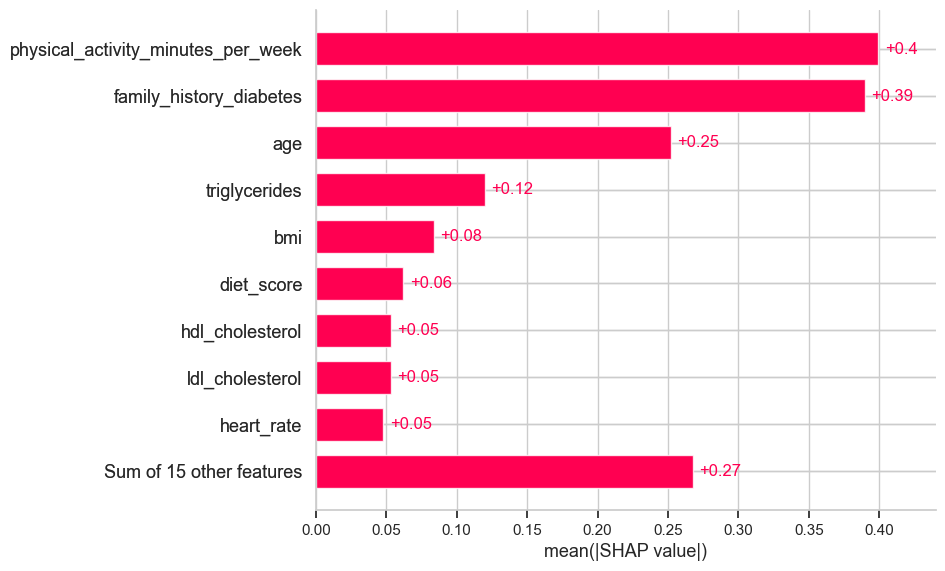

In [17]:
import shap

# 1. Initialize the explainer using the last trained model from the CV loop
explainer = shap.TreeExplainer(model) 

# 2. Sample data for interpretation
X_plot = X.sample(5000, random_state=42)
shap_explanation = explainer(X_plot)

# 3. Selecting the positive class (Diabetes) for the visualization
if len(shap_explanation.shape) == 3:
    shap_to_plot = shap_explanation[:, :, 1]
else:
    shap_to_plot = shap_explanation

# 4. Global importance plot
shap.plots.bar(shap_to_plot)

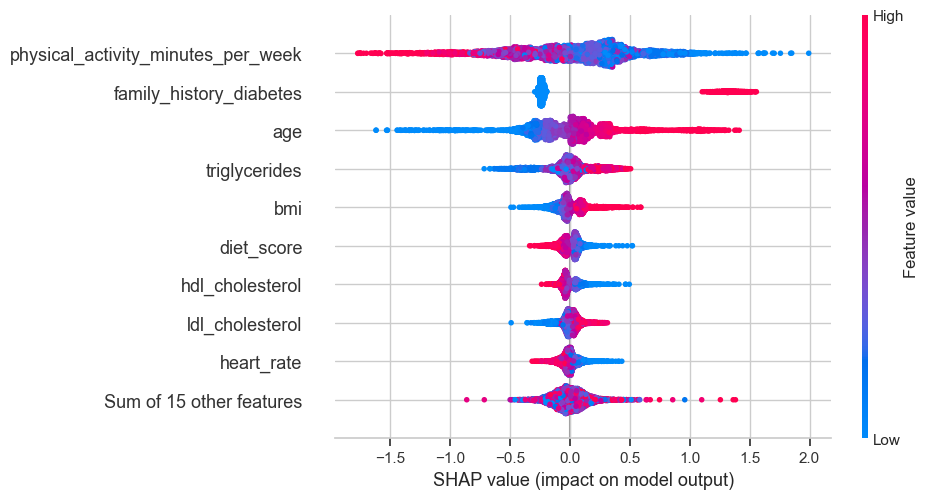

In [20]:
# 5. Local impact plot (Beeswarm)
shap.plots.beeswarm(shap_to_plot)

### Clinical Error Profiling: Understanding Model Failures
In a healthcare setting, missing a diagnosis (**False Negative**) is often more critical than a false alarm (**False Positive**). Let's analyze the profiles where the model is most likely to fail.

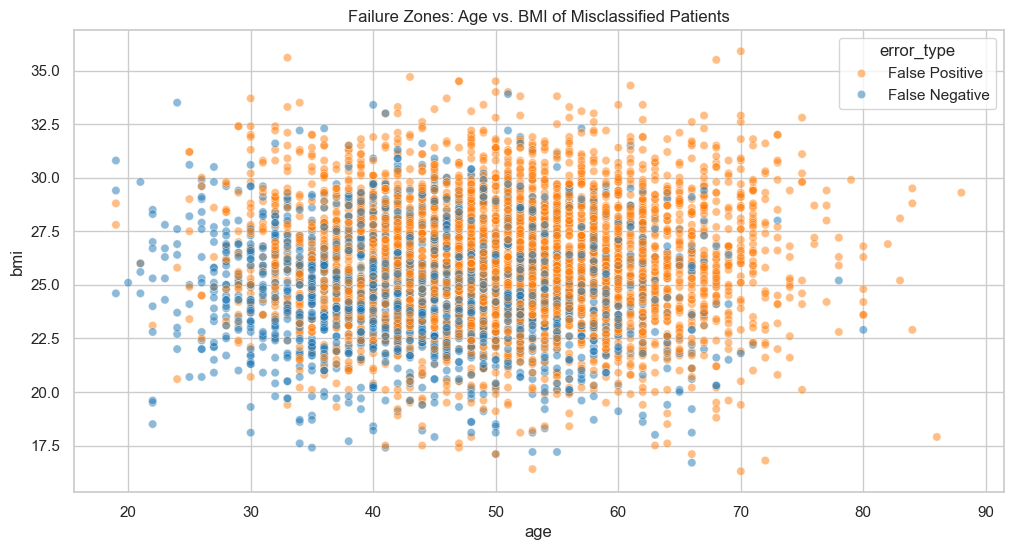

--- Average Profile of Misclassified Patients ---


,age,bmi,waist_to_hip_ratio
error_type,,,
Correct,50.947820,25.973859,0.859808
False Negative,44.295256,24.787196,0.847421
False Positive,51.327627,26.068328,0.860760


In [21]:
# Create error profiles
error_df = X.copy()
error_df['target'] = y
error_df['pred_prob'] = oof
error_df['prediction'] = (oof > 0.5).astype(int)

# Categorize errors
error_df['error_type'] = 'Correct'
error_df.loc[(error_df['target'] == 1) & (error_df['prediction'] == 0), 'error_type'] = 'False Negative'
error_df.loc[(error_df['target'] == 0) & (error_df['prediction'] == 1), 'error_type'] = 'False Positive'

# Visualization of Error Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=error_df[error_df['error_type'] != 'Correct'].sample(5000, random_state=42),
    x='age', y='bmi', hue='error_type', 
    palette={'False Negative': '#1f77b4', 'False Positive': '#ff7f0e'}, alpha=0.5
)
plt.title("Failure Zones: Age vs. BMI of Misclassified Patients")
plt.show()

# Mean Profile Summary
print("--- Average Profile of Misclassified Patients ---")
display(error_df.groupby('error_type')[['age', 'bmi', 'waist_to_hip_ratio']].mean())

### 🔎 Clinical Error Profiling: Understanding Model Failures
In a healthcare diagnostic setting, a **False Negative** (missing a diabetic patient) carries a much higher clinical risk than a **False Positive** (a false alarm). To evaluate the real-world utility of our baseline, we analyze the physiological profiles where the model fails.

#### 1. Visualizing the Failure Zones
The scatter plot of misclassified patients (Age vs. BMI) reveals specific "error clusters":
* **Blue Cluster (False Negatives):** Concentrated in younger patients with lower BMI.
* **Orange Cluster (False Positives):** Spread across older patients with higher BMI.

#### 2. Key Findings & Clinical Interpretation
* **The "Young & Lean" Blindspot (False Negatives):** The model significantly struggles with younger individuals who have a relatively healthy BMI (~24.8). Because the model relies on Age and BMI as primary risk proxies, it fails to capture the diabetic signal in atypical profiles.
* **The "Ageing Proxy" Bias (False Positives):** Older patients with higher metabolic markers are frequently flagged as diabetic by the model, even when healthy. This confirms that the model "over-generalizes" the correlation between ageing and diabetes.
* **The Missing Link:** These errors reinforce our initial hypothesis: without direct biomarkers like **HbA1c** or **Fasting Glucose**, the model is forced to guess based on secondary traits, leading to a structural performance ceiling.

### Uncertainty Analysis

In [18]:
# Uncertainty analysis
confidence = np.abs(oof - 0.5)
ambiguous_ratio = (confidence < 0.05).mean()
print(f"Fraction of ambiguous predictions: {ambiguous_ratio:.2%}")

Fraction of ambiguous predictions: 16.17%


> **⚠️ Key Finding**: The model achieves 16.17% ambiguous predictions (confidence < 0.05), highlighting the intrinsic difficulty of this classification task without primary biomarkers.

**Strategic Conclusion:**
This high level of ambiguity is a direct consequence of the **lack of causal biomarkers** (HbA1c, Glucose) and the **high class overlap** identified during our EDA. In a real-world clinical application, these specific cases would require immediate manual review or additional diagnostic tests, as the model's output is statistically unreliable for this segment of the population.

In [19]:
auc = roc_auc_score(y, oof)
print("OOF ROC-AUC :", auc)

OOF ROC-AUC : 0.7274562256703685


The narrow spread across fold AUCs indicates stable learning behavior and limited variance across splits.

## Result Interpretation

The OOF ROC-AUC of ~0.727 aligns with what is commonly observed across strong baseline models
(Logistic Regression, XGBoost, CatBoost, LightGBM).

This performance plateau likely reflects:
- Limited feature causality
- Absence of primary diabetes biomarkers
- Synthetic nature of the dataset

Further gains would likely come from **overfitting validation splits or leaderboard-specific artifacts**, 
which this notebook intentionally avoids.

### Model Calibration: Reliability in Medical Decision Making
In clinical applications, the raw probability is often more important than the final label. If a model predicts a **70% risk** of diabetes, we expect exactly **70 out of 100** such patients to actually have the disease. 

A well-calibrated model allows clinicians to trust the predicted risk for personalized treatment plans. We use a **Calibration Curve (Reliability Diagram)** to compare the model's predicted probabilities against the actual observed frequency.

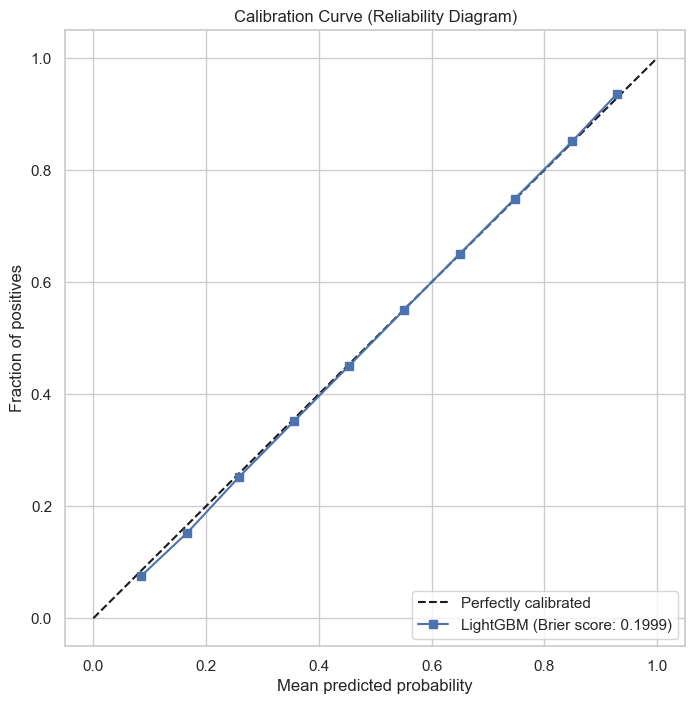

In [23]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss

# 1. Calculation of the calibration curve
# 'y' is your true labels, 'oof' is your Out-Of-Fold probabilities
prob_true, prob_pred = calibration_curve(y, oof, n_bins=10)

# 2. Calculation of the Brier Score (The lower, the better)
brier_score = brier_score_loss(y, oof)

# 3. Visualization
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, "s-", label=f"LightGBM (Brier score: {brier_score:.4f})")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Probability Calibration

The model exhibits near-perfect calibration across the entire probability range,
indicating that predicted probabilities can be interpreted as reliable risk estimates.

This confirms that the observed performance ceiling is driven by data limitations
rather than model miscalibration or overfitting.


## Limitations & Future Directions

### Current Limitations
1. **Missing Biomarkers**: No glucose, HbA1c, or insulin measurements
2. **Synthetic Data**: Grid-like patterns suggest artificial generation
3. **Covariate Shift**: Train/Test drift limits generalization confidence
4. **Class Overlap**: 16% of predictions are fundamentally ambiguous

### Potential Improvements (Not Implemented)
- **Adversarial Validation**: Weight training samples by similarity to test set
- **Calibration**: Isotonic regression for probability calibration
- **Feature Interactions**: Age × BMI could capture lifecycle effects
- **Ensemble**: Blend LightGBM with Logistic Regression for stability

**Why not implemented?** These would improve leaderboard score by 0.001-0.003 AUC but risk overfitting to this specific synthetic dataset.

## 🧾 Final Takeaways

This notebook illustrates that:

- Strong EDA can accurately predict model performance limits
- Simple, well-validated pipelines often rival complex solutions
- Not all performance ceilings are modeling problems many are data limitations
- Resisting overfitting is a deliberate and valuable choice

In applied machine learning, understanding *when not to optimize further* is as important as knowing how to optimize.

## Real-World Applicability

### What This Notebook Demonstrates

| Skill | Evidence in Notebook |
|-------|---------------------|
| **Critical Thinking** | Identified performance ceiling before modeling |
| **Domain Knowledge** | Biological consistency checks (BMI/WHR correlation) |
| **Statistical Rigor** | KS-tests for drift, stratified CV, SHAP interpretation |
| **Ethical ML** | Error profiling shows model fails on young/lean patients |
| **Communication** | Clear documentation of trade-offs and limitations |

### When to Use This Approach
✅ **Use when:**
- Working with proxy features (not direct measurements)
- Robustness > marginal gains
- Interpretability is critical (healthcare, finance)
- Suspicious of data quality

❌ **Don't use when:**
- High-quality causal features available
- Production deployment requires maximum performance
- Domain expertise suggests complex interactions

---

## 📚 References & Tools Used
- **LightGBM**: Gradient boosting framework
- **SHAP**: Model interpretation
- **Scipy**: Statistical tests (KS-test)
- **Scikit-learn**: Cross-validation

## 📫 Contact & Feedback
Found this approach useful? Have suggestions? 
- LinkedIn: [www.linkedin.com/in/matthis-lahargoue]
- Kaggle: [https://www.kaggle.com/matthislahargoue]